In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import torch
import matplotlib.pyplot as plt

# Callbacks

### Callbacks as GUI events

In [4]:
import ipywidgets as widgets

In [5]:
def f(o): print('hi')

From the [ipywidget docs](https://ipywidgets.readthedocs.io/en/stable/examples/Widget%20Events.html):

- *the button widget is used to handle mouse clicks. The on_click method of the Button can be used to register function to be called when the button is clicked*

In [6]:
w = widgets.Button(description='Click me')

In [7]:
w

Button(description='Click me', style=ButtonStyle())

hi
hi


In [8]:
w.on_click(f)

*NB: When callbacks are used in this way they are often called "events".*

Did you know what you can create interactive apps in Jupyter with these widgets? Here's an example from [plotly](https://plot.ly/python/widget-app/):

![](https://cloud.githubusercontent.com/assets/12302455/16637308/4e476280-43ac-11e6-9fd3-ada2c9506ee1.gif)

### Creating your own callback

In [9]:
from time import sleep

In [10]:
def slow_calculation():
    res = 0
    for i in range(5):
        res += i*i
        sleep(1)
    return res

In [12]:
slow_calculation()

30

In [16]:
def slow_calculation(cb=None):
    res = 0
    for i in range(5):
        res += i*i
        sleep(1)
        if cb: cb(i)
    return res

In [17]:
def show_progress(epoch):
    print(f"Awesome! We've finished epoch {epoch}!")

In [18]:
slow_calculation(show_progress)

Awesome! We've finished epoch 0!
Awesome! We've finished epoch 1!
Awesome! We've finished epoch 2!
Awesome! We've finished epoch 3!
Awesome! We've finished epoch 4!


30

## Lambdas and partials

In [20]:
slow_calculation(lambda o:  print(f"Awesome! We've finished epoch {o}!"))

Awesome! We've finished epoch 0!
Awesome! We've finished epoch 1!
Awesome! We've finished epoch 2!
Awesome! We've finished epoch 3!
Awesome! We've finished epoch 4!


30

In [23]:
def show_progress(exclamation, epoch):
    print(f"{exclamation}! We've finished epoch {epoch}!")

In [24]:
slow_calculation(lambda o: show_progress("Ok I guess", o))

Ok I guess! We've finished epoch 0!
Ok I guess! We've finished epoch 1!
Ok I guess! We've finished epoch 2!
Ok I guess! We've finished epoch 3!
Ok I guess! We've finished epoch 4!


30

In [25]:
def make_show_progress(exclamation):
    _inner = lambda epoch: print(f"{exclamation}! We've finished epoch {epoch}!")
    return _inner

In [26]:
slow_calculation(make_show_progress('Nice!'))

Nice!! We've finished epoch 0!
Nice!! We've finished epoch 1!
Nice!! We've finished epoch 2!
Nice!! We've finished epoch 3!
Nice!! We've finished epoch 4!


30

In [27]:
def make_show_progress(exclamation):
    def _inner(epoch): print(f"{exclamation}! We've finished epoch {epoch}!")
    return _inner

In [28]:
slow_calculation(make_show_progress('Amazing'))

Amazing! We've finished epoch 0!
Amazing! We've finished epoch 1!
Amazing! We've finished epoch 2!
Amazing! We've finished epoch 3!
Amazing! We've finished epoch 4!


30

In [29]:
from functools import partial

In [30]:
slow_calculation(partial(show_progress, 'OK I guess'))

OK I guess! We've finished epoch 0!
OK I guess! We've finished epoch 1!
OK I guess! We've finished epoch 2!
OK I guess! We've finished epoch 3!
OK I guess! We've finished epoch 4!


30

In [31]:
f2 = partial(show_progress, 'OK I guess')

### Callbacks as callable classes

In [32]:
class ProgressShowingCallback():
    def __init__(self, exclamation="Awesome"): self.exclamation = exclamation
    def __call__(self, epoch): print(f"{self.exclamation}! We've finished epoch {epoch}!")

In [33]:
cb = ProgressShowingCallback("Just super")

In [35]:
slow_calculation(cb)

Just super! We've finished epoch 0!
Just super! We've finished epoch 1!
Just super! We've finished epoch 2!
Just super! We've finished epoch 3!
Just super! We've finished epoch 4!


30

### Multiple callbacks funcs; *args and **kwargs

In [36]:
def f(*args, **kwargs): print(f"args: {args}; kwargs: {kwargs}")

In [37]:
f(3, 'a', thing1="hello")

args: (3, 'a'); kwargs: {'thing1': 'hello'}


In [38]:
def slow_calculation(cb=None):
    res = 0
    for i in range(5):
        if cb: cb.before_calc(i)
        res += i*i
        sleep(1)
        if cb: cb.after_calc(i, val=res)
    return res

In [39]:
#here we don't use the epoch or the calculated value
class PrintStepCallback():
    def __init__(self): pass
    def before_calc(self, *args, **kwargs): print(f"About to start")
    def after_calc (self, *args, **kwargs): print(f"Done step")

In [40]:
slow_calculation(PrintStepCallback())

About to start
Done step
About to start
Done step
About to start
Done step
About to start
Done step
About to start
Done step


30

In [41]:
#here we use the epoch and the calculated value
class PrintStatusCallback():
    def __init__(self): pass
    def before_calc(self, epoch, **kwargs): print(f"About to start: {epoch}")
    def after_calc (self, epoch, val, **kwargs): print(f"After {epoch}: {val}")

In [42]:
slow_calculation(PrintStatusCallback())

About to start: 0
After 0: 0
About to start: 1
After 1: 1
About to start: 2
After 2: 5
About to start: 3
After 3: 14
About to start: 4
After 4: 30


30

### Modify behavior

In [45]:
def slow_calculation(cb=None):
    res = 0
    for i in range(5):
        if cb and hasattr(cb, 'before_calc'): cb.before_calc(i)
        res += i*i
        sleep(1)
        if cb and hasattr(cb, 'after_calc'): 
            if cb.after_calc(i ,res):
                print("stopping early")
                break
    return res

In [46]:
class PrintAfterCallback():
    def after_calc(self, epoch, val):
        print(f"After {epoch}: {val}")
        if val>10: return True

In [47]:
slow_calculation(PrintAfterCallback())

After 0: 0
After 1: 1
After 2: 5
After 3: 14
stopping early


14

In [52]:
class SlowCalculator():
    def __init__(self, cb=None): self.cb,self.res = cb,0
    
    def callback(self, cb_name, *args):
        if not self.cb: return
        cb = getattr(self.cb,cb_name, None)
        if cb: return cb(self, *args)

    def calc(self):
        for i in range(5):
            self.callback('before_calc', i)
            self.res += i*i
            sleep(1)
            if self.callback('after_calc', i):
                print("stopping early")
                break

In [53]:
class ModifyingCallback():
    def after_calc (self, calc, epoch):
        print(f"After {epoch}: {calc.res}")
        if calc.res>10: return True
        if calc.res<3: calc.res = calc.res*2

In [54]:
calculator = SlowCalculator(ModifyingCallback())

In [55]:
calculator.calc()
calculator.res

After 0: 0
After 1: 1
After 2: 6
After 3: 15
stopping early


15

## `__dunder__` thingies

Anything that looks like `__this__` is, in some way, *special*. Python, or some library, can define some functions that they will call at certain documented times. For instance, when your class is setting up a new object, python will call `__init__`. These are defined as part of the python [data model](https://docs.python.org/3/reference/datamodel.html#object.__init__).

For instance, if python sees `+`, then it will call the special method `__add__`. If you try to display an object in Jupyter (or lots of other places in Python) it will call `__repr__`.

In [60]:
class SloppyAdder():
    def __init__(self,o): self.o=o
    def __add__(self,b): return SloppyAdder(self.o + b.o + 0.01)
    def __repr__(self): return str(self.o)

In [61]:
a = SloppyAdder(1)
b = SloppyAdder(2)
a + b

3.01

## Variance

Variance is the average of how far away each data point is from the mean

In [63]:
t = torch.tensor([1.,2.,4.,18])

In [64]:
m = t.mean(); m

tensor(6.2500)

In [65]:
(t-m).mean()

tensor(0.)

Oops. We can't do that. Because by definition the positives and negatives cancel out. So we can fix that in one of (at least) two ways:

In [66]:
#this is variance
(t-m).pow(2).mean()

tensor(47.1875)

In [67]:
#this is mean absolute deviation
(t-m).abs().mean()

tensor(5.8750)

But the first of these is now a totally different scale, since we squared. So let's undo that at the end.

In [68]:
#this is standard deviation
(t-m).pow(2).mean().sqrt()

tensor(6.8693)

They're still different. Why?

Note that we have one outlier (`18`). In the version where we square everything, it makes that much bigger than everything else.

`(t-m).pow(2).mean()` is refered to as **variance**. It's a measure of how spread out the data is, and is particularly sensitive to outliers.

When we take the sqrt of the variance, we get the **standard deviation**. Since it's on the same kind of scale as the original data, it's generally more interpretable. However, since `sqrt(1)==1`, it doesn't much matter which we use when talking about *unit variance* for initializing neural nets.

`(t-m).abs().mean()` is referred to as the **mean absolute deviation**. It isn't used nearly as much as it deserves to be, because mathematicians don't like how awkward it is to work with. But that shouldn't stop us, because we have computers and stuff.

Here's a useful thing to note about variance:

In [69]:
(t-m).pow(2).mean(), (t*t).mean() - (m*m)

(tensor(47.1875), tensor(47.1875))

You can see why these are equal if you want to work thru the algebra. Or not.

But, what's important here is that the latter is generally much easier to work with. In particular, you only have to track two things: the sum of the data, and the sum of squares of the data. Whereas in the first form you actually have to go thru all the data twice (once to calculate the mean, once to calculate the differences).

Let's go steal the LaTeX from [Wikipedia](https://en.wikipedia.org/wiki/Variance):

$$\operatorname{E}\left[X^2 \right] - \operatorname{E}[X]^2$$

### Covariance and correlation

Here's how Wikipedia defines covariance:

$$\operatorname{cov}(X,Y) = \operatorname{E}{\big[(X - \operatorname{E}[X])(Y - \operatorname{E}[Y])\big]}$$

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=2414)

In [70]:
t

tensor([ 1.,  2.,  4., 18.])

Let's see that in code. So now we need two vectors.

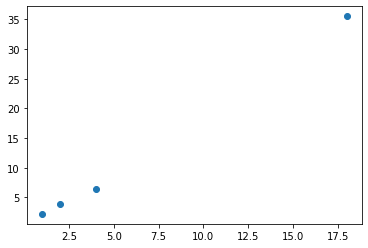

In [71]:
# `u` is twice `t`, plus a bit of randomness
u = t*2
u *= torch.randn_like(t)/10+0.95

plt.scatter(t, u);

In [72]:
prod = (t-t.mean())*(u-u.mean()); prod

tensor([ 51.3928,  34.6400,  12.5830, 276.5027])

In [73]:
prod.mean()

tensor(93.7796)

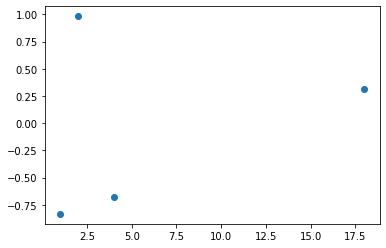

In [74]:
v = torch.randn_like(t)
plt.scatter(t, v);

In [75]:
((t-t.mean())*(v-v.mean())).mean()

tensor(1.3625)

It's generally more conveniently defined like so:

$$\operatorname{E}\left[X Y\right] - \operatorname{E}\left[X\right] \operatorname{E}\left[Y\right]$$

In [76]:
cov = (t*v).mean() - t.mean()*v.mean(); cov

tensor(1.3625)

From now on, you're not allowed to look at an equation (or especially type it in LaTeX) without also typing it in Python and actually calculating some values. Ideally, you should also plot some values.

Finally, here is the Pearson correlation coefficient:

$$\rho_{X,Y}= \frac{\operatorname{cov}(X,Y)}{\sigma_X \sigma_Y}$$

In [77]:
cov / (t.std() * v.std())

tensor(0.2000)

It's just a scaled version of the same thing. Question: *Why is it scaled by standard deviation, and not by variance or mean or something else?*

## Softmax

Here's our final `logsoftmax` definition:

In [78]:
def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log()

which is:

$$\hbox{logsoftmax(x)}_{i} = x_{i} - \log \sum_{j} e^{x_{j}}$$ 

And our cross entropy loss is:
$$-\log(p_{i})$$